In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklego.datasets import load_hearts
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklego.preprocessing import PandasTypeSelector

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import DiscriminationThreshold

from sklego.meta import Thresholder
from sklearn.metrics import classification_report

In [3]:
data = load_hearts(as_frame=True)
X, y = data.drop(columns='target'), data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

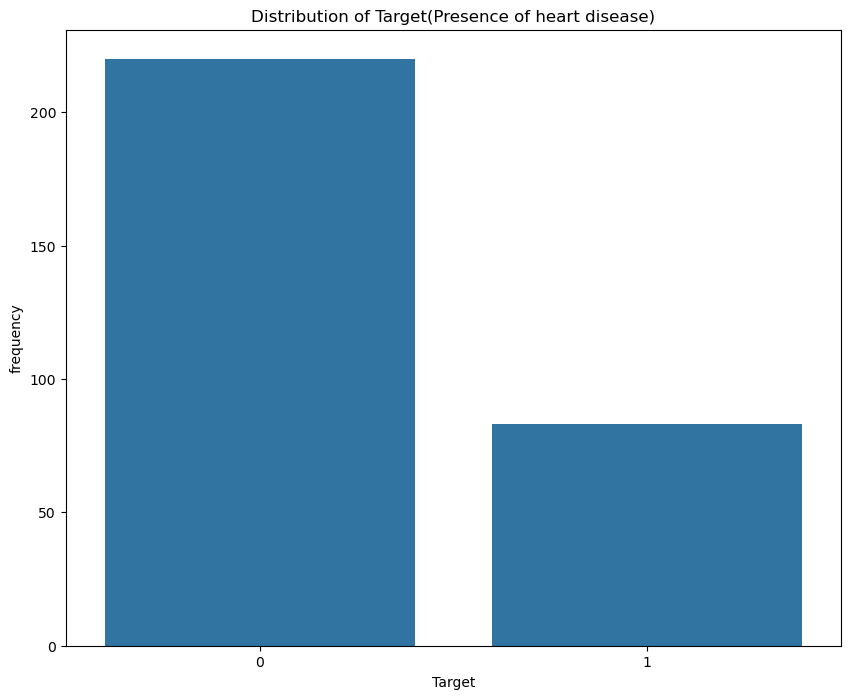

In [5]:
# visualize the the distribution of the target variable
plt.figure(figsize=[10,8])
sns.countplot(
    data=data,
    x="target"
)
plt.title("Distribution of Target(Presence of heart disease)")
plt.ylabel("frequency")
plt.xlabel("Target")
plt.show()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


## Preprocessing

In [8]:
cat_features_preprocessing = make_pipeline(
    PandasTypeSelector(exclude="number"),
    SimpleImputer(strategy='constant', fill_value='unkown'),
    OneHotEncoder(categories=[['normal', 'sth', 'fixed']], handle_unknown='ignore')
)

num_features_preprocessing = make_pipeline(
    PandasTypeSelector(include='number'),
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessor = make_union(cat_features_preprocessing, num_features_preprocessing)

C:\Users\HP\AppData\Local\Temp\ipykernel_33924\1402580782.py:2: DeprecationWarning: PandasTypeSelector is deprecated and will be removed in a future version. Please use `from sklego.preprocessing import TypeSelector` instead.
  PandasTypeSelector(exclude="number"),
C:\Users\HP\AppData\Local\Temp\ipykernel_33924\1402580782.py:8: DeprecationWarning: PandasTypeSelector is deprecated and will be removed in a future version. Please use `from sklego.preprocessing import TypeSelector` instead.
  PandasTypeSelector(include='number'),


## Model Training

In [12]:
lr_clf = LogisticRegression(random_state=42)
pipe = make_pipeline(
    preprocessor, lr_clf
)

params = {
    "logisticregression__C": np.logspace(-3, 1,10),
    "logisticregression__penalty": ["l1", "l2"],
    "logisticregression__solver": ["liblinear"]
    
}

grid = GridSearchCV(
    pipe,
    param_grid=params,
    cv=5,
    scoring="average_precision",
    n_jobs=-1,
    return_train_score=True
)

grid.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'logisticregression__C': array([1.0000...00000000e+01]), 'logisticregression__penalty': ['l1', 'l2'], 'logisticregression__solver': ['liblinear']}"
,scoring,'average_precision'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformer_list,"[('pipeline-1', ...), ('pipeline-2', ...)]"


In [13]:
grid.best_params_

{'logisticregression__C': np.float64(0.05994842503189409),
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'liblinear'}

In [15]:
print(grid.best_score_)
best_model = grid.best_estimator_

0.8150170440666729


## Tuning the Decision Threshold

C:\Users\HP\miniconda3\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


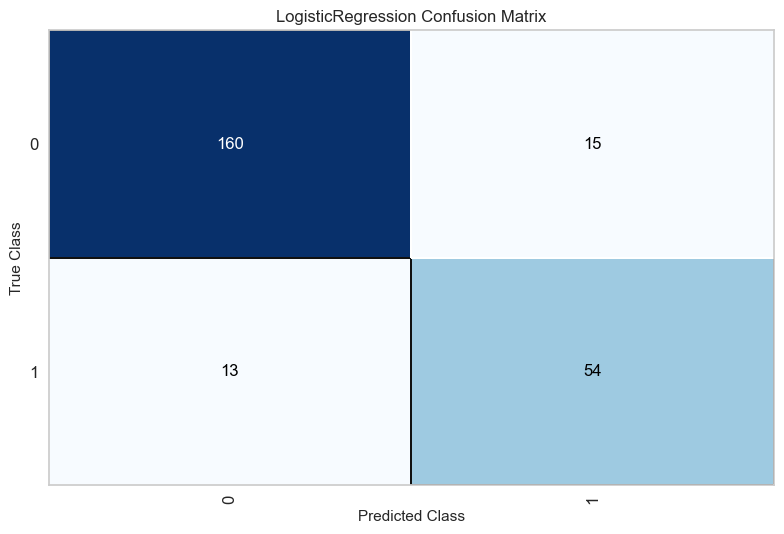

In [16]:
cm = ConfusionMatrix(best_model, cmap="Blues")
cm.score(X_train, y_train)
cm.show();

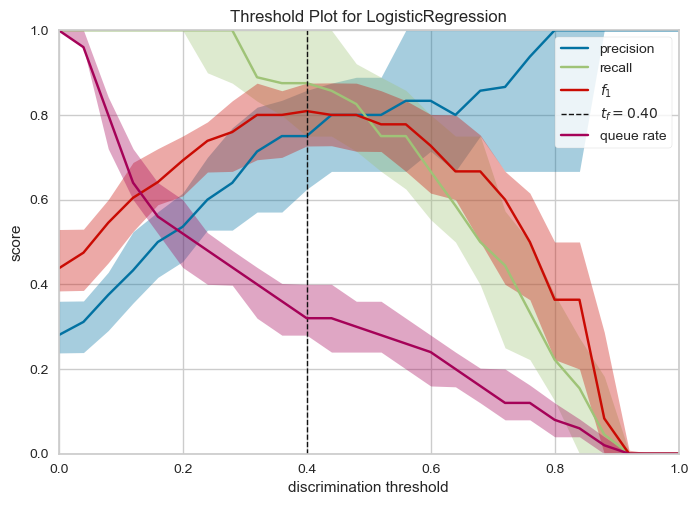

In [19]:
visualizer = DiscriminationThreshold(best_model, quantiles=np.array([0.25, 0.5, 0.75]))

visualizer.fit(X_train, y_train)
visualizer.show();

In [21]:
best_threshold = visualizer.thresholds_[visualizer.cv_scores_[visualizer.argmax].argmax()]
best_threshold

np.float64(0.4)

In [27]:
best_threshold = visualizer.thresholds_[visualizer.cv_scores_[visualizer.argmax].argmax()]
pipe = Thresholder(best_model, best_threshold, refit= False)
pipe.fit(X_train, y_train)

,model,Pipeline(step...liblinear'))])
,threshold,np.float64(0.4)
,refit,False
,check_input,False
,transformer_list,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,include,None
,exclude,'number'


In [29]:
y_train_pred = pipe.predict(X_train)

In [31]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       175
           1       0.74      0.88      0.80        67

    accuracy                           0.88       242
   macro avg       0.84      0.88      0.86       242
weighted avg       0.89      0.88      0.88       242



In [32]:
y_test_pred = pipe.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.78      0.84        45
           1       0.57      0.81      0.67        16

    accuracy                           0.79        61
   macro avg       0.74      0.80      0.76        61
weighted avg       0.83      0.79      0.80        61

